In [53]:
# The dataset has 13 fields.

# date - date of publication of the announcement;
# time - the time when the ad was published;
# geo_lat - Latitude
# geo_lon - Longitude
# region - Region of Russia. There are 85 subjects in the country in total.
# building_type - Facade type. 0 - Other. 1 - Panel. 2 - Monolithic. 3 - Brick. 4 - Blocky. 5 - Wooden
# object_type - Apartment type. 1 - Secondary real estate market; 2 - New building;
# level - Apartment floor
# levels - Number of storeys
# rooms - the number of living rooms. If the value is "-1", then it means "studio apartment"
# area - the total area of ​​the apartment square meters
# kitchen_area - Kitchen area
# price - Price. in rubles
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
import pandas as pd
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from matplotlib.dates import date2num 
from scipy import stats
import matplotlib.dates as dates
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier 
from pandas_profiling import ProfileReport
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, roc_curve, plot_confusion_matrix, plot_roc_curve, mean_absolute_error, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
df = pd.read_csv('russian_homes.csv')

In [4]:
#Read in data, set the date as the index col, remove extreme outliers in the price column
def wrangle(filepath):
    df = pd.read_csv(filepath, parse_dates=['date'], index_col='date')
    df.drop(['time'],axis=1,inplace=True)
    df = df.drop_duplicates()
    
    return df

df = wrangle('russian_homes.csv')

overfivemil = df[df['price']>=365865000].index  
df.drop(overfivemil, inplace=True)

guh2 = df[df['price']<10000].index  
df.drop(guh2, inplace=True)


df.head()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
date,,,,,,,,,,,
2018-02-19,6050000,59.805808,30.376141,2661,1,8,10,3,82.6,10.8,1
2018-02-27,8650000,55.683807,37.297405,81,3,5,24,2,69.1,12.0,1
2018-02-28,4000000,56.295250,44.061637,2871,1,5,9,3,66.0,10.0,1
2018-03-01,1850000,44.996132,39.074783,2843,4,12,16,2,38.0,5.0,11
2018-03-01,5450000,55.918767,37.984642,81,3,13,14,2,60.0,10.0,1


In [5]:
#define y variable 
target = 'building_type'
y = df[target]
X = df.drop(columns=target)

In [6]:
#split data into train and test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
print('Baseline Accuracy Score:', y_train.value_counts(normalize=True).max())

Baseline Accuracy Score: 0.37373224792227056


In [8]:
#initial models 'not tuned'
model_rf = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=25)
)

model_rf.fit(X_train, y_train);

In [9]:
#initial models 'not tuned'
model_xgb = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_jobs=-1, n_estimators=25)
)

model_xgb.fit(X_train, y_train);

[22:53:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [10]:
print('sklearn Training Accuracy:', model_rf.score(X_train, y_train))
print('sklearn Validation Accuracy:', model_rf.score(X_val, y_val))

sklearn Training Accuracy: 0.9968346120270548
sklearn Validation Accuracy: 0.7592530819949042


In [11]:
print('XGBoost Training Accuracy:', model_xgb.score(X_train, y_train))
print('XGBoost Validation Accuracy:', model_xgb.score(X_val, y_val))

XGBoost Training Accuracy: 0.6737893810459975
XGBoost Validation Accuracy: 0.6697279611636704


In [12]:
#model tuning
model_rf2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42, n_jobs=-1, n_estimators=25)
)


In [19]:
params={
    
    'randomforestclassifier__max_depth'        : range(80, 200, 20),
    'randomforestclassifier__min_samples_leaf' : range(250, 360, 20),
    'randomforestclassifier__max_samples'      : [.1, .2, .3, .4, .5, .6, .7, .8, .9],
    'randomforestclassifier__max_leaf_nodes'   : range(200, 400, 25),
    'randomforestclassifier__min_samples_split': [14, 16, 18, 20, 22, 24, 26]
}

In [20]:
model_RfR = RandomizedSearchCV(
    model_rf2, 
    param_distributions=params,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_RfR.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_estimators=25,
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(80, 200, 20),
                                        'randomforestclassifier__max_leaf_nodes': range(200, 400, 25),
                                        'randomforestclassifier__max_samples': [0.1,
                                                                                0.2,
                                     

In [21]:
best_score = model_RfR.best_score_
best_params = model_RfR.best_params_

print('Best score for `model`:', best_score)
print()
print('Best params for `model`:', best_params)

Best score for `model`: 0.6507906325918178

Best params for `model`: {'randomforestclassifier__min_samples_split': 20, 'randomforestclassifier__min_samples_leaf': 310, 'randomforestclassifier__max_samples': 0.7, 'randomforestclassifier__max_leaf_nodes': 350, 'randomforestclassifier__max_depth': 120}


In [24]:
#model tuning
model_xgb2 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_jobs=-1, n_estimators=25)
)

model_xgb2.fit(X_train, y_train);

[23:18:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [25]:
param={
    'xgbclassifier__learning_rate'   : [0.03, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'xgbclassifier__max_depth'       : range(80, 200, 20),
    'xgbclassifier__min_child_weight': [8, 9, 10, 11, 12, 13, 14],
    'xgbclassifier__gamma'           : [0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
    'xgbclassifier__colsample_bytree': [0.01, 0.02, 0.3, 0.4, 0.5, 0.7, 0.08, 0.09]  
}

In [26]:
model_RfR2 = RandomizedSearchCV(
    model_xgb2, 
    param_distributions=param,
    n_iter=10,
    cv=5,
    n_jobs=-1,
    verbose=1
)

model_RfR2.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[00:11:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('xgbclassifier',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            gamma=None,
                                                            gpu_id=None,
                                                            importance_type='gain',
                                                            interaction_

In [27]:
best_score = model_RfR2.best_score_
best_params = model_RfR2.best_params_

print('Best score for `model`:', best_score)
print()
print('Best params for `model`:', best_params)

Best score for `model`: 0.7680306450489809

Best params for `model`: {'xgbclassifier__min_child_weight': 13, 'xgbclassifier__max_depth': 140, 'xgbclassifier__learning_rate': 0.25, 'xgbclassifier__gamma': 0.4, 'xgbclassifier__colsample_bytree': 0.5}


In [29]:
#Final model
model_xgb3 = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    XGBClassifier(random_state=42, n_jobs=-1, n_estimators=25, min_child_weight=13, max_depth=40, learning_rate=0.25, gamma=0.4, colsample_bytree=0.5)
)

model_xgb3.fit(X_train, y_train);

[00:28:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [30]:
print('XGBoost Training Accuracy:', model_xgb3.score(X_train, y_train))
print('XGBoost Validation Accuracy:', model_xgb3.score(X_val, y_val))

XGBoost Training Accuracy: 0.8886773504425156
XGBoost Validation Accuracy: 0.7755768316311684


In [31]:
perm_imp = permutation_importance(model_xgb3, 
                                  X_val, 
                                  y_val, 
                                  n_repeats=5, 
                                  n_jobs=-1, 
                                  random_state=42)

In [32]:
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}

importances = pd.DataFrame(data, index=X_val.columns).sort_values(by='imp_mean')

importances.head()

,imp_mean,imp_std
level,0.003967,0.000230
rooms,0.017418,0.000216
price,0.028667,0.000569
area,0.029491,0.000513
region,0.029901,0.000241


<AxesSubplot:>

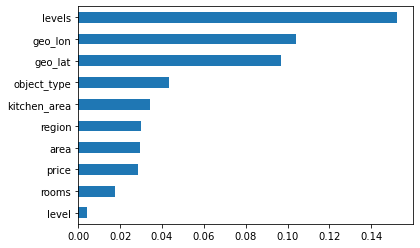

In [33]:
importances['imp_mean'].tail(10).plot(kind='barh')

Random Forest
              precision    recall  f1-score   support

           0       0.66      0.43      0.52      6771
           1       0.83      0.83      0.83     42259
           2       0.75      0.80      0.78     33929
           3       0.77      0.81      0.79     52619
           4       0.64      0.33      0.43      4852
           5       0.69      0.40      0.51       469

    accuracy                           0.78    140899
   macro avg       0.72      0.60      0.64    140899
weighted avg       0.77      0.78      0.77    140899



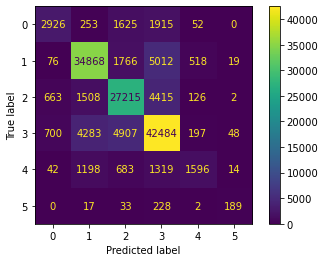

In [38]:
print("Random Forest")
print(classification_report(y_val, model_xgb3.predict(X_val)))
plot_confusion_matrix(model_xgb3, X_val, y_val);